In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from statistics import stdev

In [3]:
import datetime as dt
from sqlalchemy import and_, or_, not_

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)    # Create the inspector and connect it to the engine
inspector.get_table_names()   # Collect the names of tables within the database

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#calculate one year before last date in date set
# get last date
last_tuple=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date=last_tuple[0]

# find "1 year ago"
date_list=last_date.split('-')
year=int(date_list[0])
month=int(date_list[1])
day=int(date_list[2])
year_ago= dt.date(year,month,day) - dt.timedelta(days=365)
year_ago_date_str=str(year_ago)
year_ago_date_str

'2016-08-23'

In [14]:
# query previous years data
data_set=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago_date_str).order_by(Measurement.date)
# put into dataframe
date_index=[record[0] for record in data_set]
prcp_values=[record[1] for record in data_set]
data_df=pd.DataFrame(prcp_values,index=date_index,columns=['prcp'])
# remove rows with null values
data_df=data_df.dropna()
data_df.head()

,prcp
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


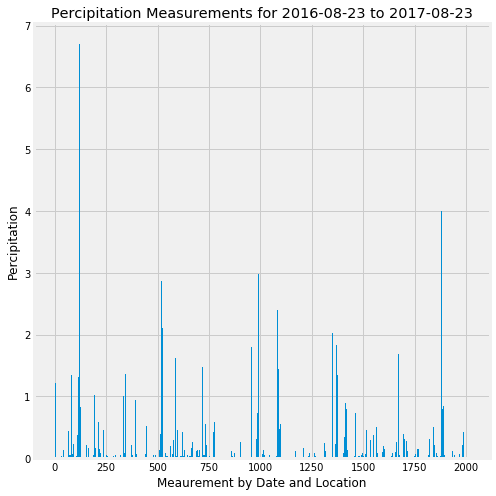

In [15]:
#plot by precip measurement
x_axis=np.arange(0,len(data_df),1)
fig,ax=plt.subplots(figsize=(7,7))
ax.bar(x_axis,data_df['prcp'])
title=f"Percipitation Measurements for {year_ago_date_str} to {last_date}"
ax.set_title(title)
ax.set_xlabel('Meaurement by Date and Location')
ax.set_ylabel("Percipitation")
fig.tight_layout()
plt.savefig("Images/my_percipitation.png")
plt.show()

In [16]:
#calculate summary statistics for percipitation data
summary_df=pd.DataFrame([[data_df['prcp'].count()],
                       [data_df['prcp'].mean()] , 
                       [stdev(data_df['prcp'])],
                       [ data_df['prcp'].min() ],
                       [ np.percentile(data_df['prcp'],25) ],
                       [ np.percentile(data_df['prcp'],50) ],
                       [ np.percentile(data_df['prcp'],75) ],
                       [ data_df['prcp'].max() ]                       
                      ],
                      index=[ 'Count','Mean', 'Std','Min','25%','50%', '75%','Max' ],
                     columns=['Percipitation'])
summary_df

,Percipitation
Count,2015.000000
Mean,0.176462
Std,0.460288
Min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
Max,6.700000


In [17]:
#working
start='2016-08-23'
sel=[func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)]
stats_entrys=session.query(*sel).filter(Measurement.date>start).all()
for record in stats_entrys:
    print(record)

(58.0, 74.57894736842105, 87.0)


In [18]:
#working
sta=engine.execute("select * from Station limit 5").fetchall()
for record in sta:
    print(record)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


In [19]:
# count distinct stations
station_count=session.query(Measurement.station).distinct().count()
print(f"The total number of stations is {station_count}")

The total number of stations is 9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# find most active station at the top of the list order descending 
#join tables on station to get name and count
sel=[Station.name,Measurement.station,func.count(Measurement.prcp)]

station_entrys=session.query(*sel).filter(Station.station == Measurement.station).\
                            group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).first()
active_station=station_entrys[1]
print(f"The station with the most measurement entries is station {active_station} named {station_entrys[0]} \n")
print("The station activity levels are as follows:")

# List the stations and the counts in descending order.
station_entrys=session.query(*sel).filter(Station.station == Measurement.station).\
                            group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

for record in station_entrys:
    print(f"{record[0]:40}  {record[1]}\t {record[2]}")

The station with the most measurement entries is station USC00519281 named WAIHEE 837.5, HI US 

The station activity levels are as follows:
WAIHEE 837.5, HI US                       USC00519281	 2772
KANEOHE 838.1, HI US                      USC00513117	 2696
WAIKIKI 717.2, HI US                      USC00519397	 2685
WAIMANALO EXPERIMENTAL FARM, HI US        USC00519523	 2572
MANOA LYON ARBO 785.2, HI US              USC00516128	 2484
KUALOA RANCH HEADQUARTERS 886.9, HI US    USC00514830	 1937
HONOLULU OBSERVATORY 702.2, HI US         USC00511918	 1932
PEARL CITY, HI US                         USC00517948	 683
UPPER WAHIAWA 874.3, HI US                USC00518838	 342


    ## The instructions in the next part and in the README seem different, I did the next query for the last 12 mo of data so the info can be used for the histogram which follows


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for most active station?

sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

temp_stat_tup=session.query(*sel).filter(and_(Measurement.station==active_station, Measurement.date > year_ago_date_str)).all()
temp_stat=temp_stat_tup[0]

min_temp=temp_stat[0]
max_temp=temp_stat[1]
print(f"For {active_station} the most activly reporting station, for the last 12 months")
print(f" The lowest temp is {min_temp} \n the highest temp is {max_temp} \n and the average temp is {temp_stat[2]}")

For USC00519281 the most activly reporting station, for the last 12 months
 The lowest temp is 59.0 
 the highest temp is 83.0 
 and the average temp is 73.0968660968661


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
temp_tuple=session.query(Measurement.tobs).\
filter(and_(Measurement.station==active_station, Measurement.date > year_ago_date_str)).order_by(Measurement.tobs).all()

temp_list=[tup[0] for tup in temp_tuple]
temp_df=pd.DataFrame(temp_list,columns=['tobs'])
temp_df.head()

,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


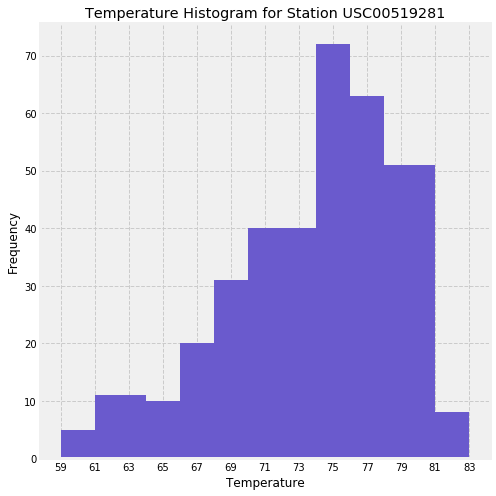

In [39]:
#plot the results as a histogram
bins=[59,61,64,66,68,70,72,74,76,78,81,83]
fig,ax=plt.subplots(figsize=(7,7))
ax.hist(temp_df['tobs'],bins=bins,range=(min_temp,max_temp),histtype='bar',color='slateblue')
x_axis=np.arange(59,85,2)
#ax.set_xticks(bins)
ax.set_xticks(x_axis)
ax.grid(linestyle='--')
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
ax.set_title(f"Temperature Histogram for Station {active_station}")
plt.tight_layout()
# Save the Figure
fig.savefig("Images/my_histogram.png")
# Show the Figure 
plt.show()

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date= str(dt.date(2017,1,7) - dt.timedelta(days=365))
end_date= str(dt.date(2017,1,21) - dt.timedelta(days=365))

temp_data=calc_temps(start_date,end_date)

1 69.17045454545455 [[8.170454545454547], [8.829545454545453]]


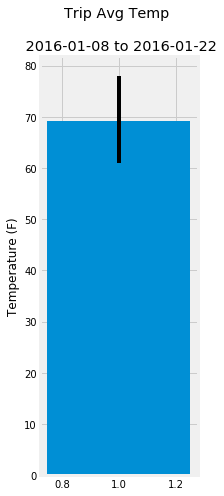

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# example data
x = 1
y = temp_data[0][1]
min=temp_data[0][0]
max=temp_data[0][2]
lower=y-min
upper=max-y
range=[[lower],[upper]]

fig,ax=plt.subplots(figsize=(3,7))
ax.bar(x, y, width=0.5, yerr=range,  align='center')
ax.set_ylabel("Temperature (F)")
ax.set_title(f"Trip Avg Temp \n \n {start_date} to {end_date}")
plt.tight_layout()
# Save the Figure
fig.savefig("Images/triptemp.png")
# Show the Figure 
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
